# Clots vs. Not-clots Mentions

In [1]:
import pandas as pd
from functools import reduce
from datetime import date, timedelta,datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ANALYZE_DAYS = True

In [3]:
df = pd.read_pickle("../full_db.pkl")

df = df[df.entities.str.len()>0]
df = df[~df.sentiment_value.isna()]
df = df[df.created_at < "2021-09-07"]

new_df = []
for idx, row in df.iterrows():
    d = row.to_dict()
    for vax in d["vaccines"]:
        d2 = d.copy()
        del d2["vaccines"]
        d2["vaccine_name"] = vax
        new_df.append(d2)
df = pd.DataFrame(new_df)

# df.created_at = pd.to_datetime(df.created_at)

In [4]:
def get_interval_dates():

    sdate = date(2020, 12, 10)   # start date
    edate = date(2021, 9, 6)     # end date

    delta = edate - sdate       # as timedelta

    dates = []
    for i in range(delta.days + 1):
        new_date = sdate + timedelta(days=i)
        txt_date = f"{new_date.year}-{new_date.strftime('%m')}"
        if ANALYZE_DAYS:
            txt_date += f"-{new_date.strftime('%d')}"
        dates.append(txt_date)
    return list(set(dates))

In [5]:
df["norm_eng"] = df.entities.apply(lambda x: [ent["text"]["norm_eng"] for ent in x])
# calculate if there are some mentions of clots
mask = [(df.norm_eng.apply(lambda x: w in x)) for w in ["ischemic stroke", "ischemic", "ischemy", "ischemia", "ischaemia", "thrombosis", "embolism", "embolus", "ictus", "apoplexy", "blockage", "clotting", "coagulation", "coronary", "coronary thrombosis", "occlusion", "seizure", "clot", "blockade", "fit", "collapse", "CVA", "cerebrovascular accident", "cerebral vascular accident", "cerebral haemorrhage"]]
mask = reduce(lambda x,y: x|y, mask, [False]*len(df))
df["clots_cit"] = mask

In [6]:
# count frequencies for each vaccine
vaccines_dfs = df.groupby("vaccine_name")
dates =  sorted(get_interval_dates())
clots_cit = {}

for vaccine_name, data in vaccines_dfs:
    if vaccine_name == "astrazeneca":
        clots_cit[vaccine_name] = {'date': [], 'freq_cit': [], 'freq_not_cit': []}
        months_dfs = data.groupby("created_at")
        for _date in dates:
            exists_date = _date in months_dfs.groups.keys()
            if exists_date:
                d = months_dfs.get_group(_date)

            clots_cit[vaccine_name]['date'].append(_date)
            clots_cit[vaccine_name]['freq_cit'].append(d[d.clots_cit].tweet_id.unique().shape[0] if exists_date else 0.0)
            clots_cit[vaccine_name]['freq_not_cit'].append(d[~d.clots_cit].tweet_id.unique().shape[0] if exists_date else 0.0)

        # remove break if you want the other vaccines
        break

            

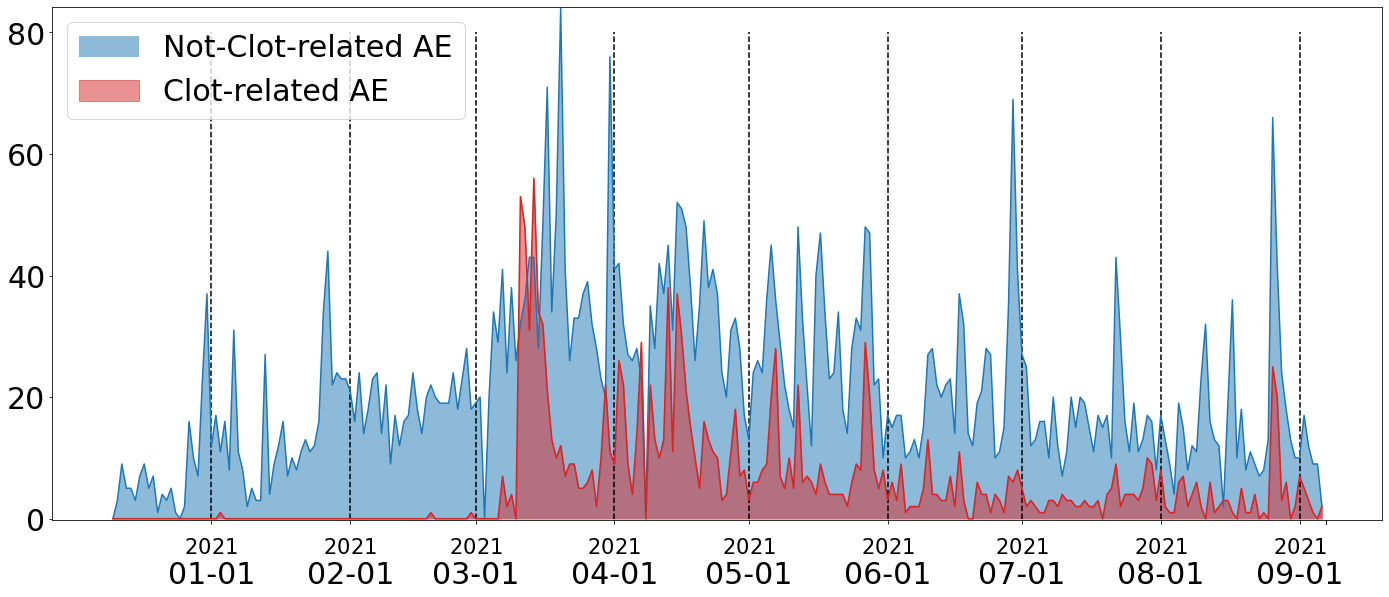

In [7]:
# plot clots citation for each vaccine

x_dates = [f"$_{{{d.split('-')[0]}}}$\n{d.split('-')[1]}-{d.split('-')[2]}" for d in sorted(get_interval_dates())]

plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.ymargin'] = 0.003

plt.figure(figsize=(20,9))
for vaccine_name, freqs in clots_cit.items():
    if vaccine_name == "astrazeneca":
        plt.fill_between(x_dates, freqs['freq_not_cit'], label="Not-Clot-related AE", alpha=0.5)
        plt.fill_between(x_dates, freqs['freq_cit'], label="Clot-related AE", alpha=0.5, color="tab:red")
        plt.plot(x_dates, freqs['freq_not_cit'])
        plt.plot(x_dates, freqs['freq_cit'], color="tab:red")

for _date in x_dates:
    if _date[-2:] == "01":
        plt.vlines(_date,ymin=0,ymax=80, colors="k", linestyles="dashed")

plt.legend()
plt.yticks([a for a in range(0,90,10) if a%20==0])
dates_to_print = [d if d[-2:] in ["01"] else "" for d in x_dates]

plt.xticks(dates_to_print, fontsize=30)#, rotation='30', ha="right")
plt.tight_layout()
plt.savefig("output/plot_clots_vs_notclots.pdf")
plt.show()